In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    

import torch
import hydra
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

In [2]:
from omegaconf import OmegaConf

def resolve_tuple(*args):
    return tuple(args)

def multiply(a, b):
    return a * b

OmegaConf.register_new_resolver("as_tuple", resolve_tuple)
OmegaConf.register_new_resolver("multiply", multiply)

In [16]:
with hydra.initialize(config_path="breaching/config", version_base="1.1"):
    cfg = hydra.compose(config_name="Adam_cfg", overrides=["+experiment=fedavg_learning_rate_single"])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

from omegaconf import open_dict
with open_dict(cfg):
    cfg.case.user.local_learning_rate=0.1
    cfg.seed = 42
    cfg.case.impl.deterministic =  True
#     cfg.case.user.num_data_points = 4
    cfg.case.model = "custom_McMahan_32_32"
    cfg.case.data.vocab_size = 100 # issue if not setup
#     cfg.attack.optim.step_size = 0.1
#     cfg.attack.objective.scale = 1e-4
#     cfg.attack.optim.langevin_noise = 1e-5
#     cfg.case.server.provide_public_buffers = False
#     cfg.case.user.provide_buffers = True
#     cfg.attack.optim.max_iterations = 2_400 * 1
#     cfg.attack.regularization.norm.scale = 1e-6
#     cfg.attack.regularization.total_variation.scale = 1e-4
#     cfg.attack.regularization.deep_inversion.scale = 1e-3
    # cfg.attack.regularization.deep_inversion.first_bn_multiplier = 10.
def get_setup(cfg, setup):
    user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
    attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)
    return user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data
def main(cfg, setup):
    user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data = get_setup(cfg, setup)
    breaching.utils.overview(server, user, attacker)
    reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)
    metrics = breaching.analysis.report(
        reconstructed_user_data, 
        true_user_data,
        [server_payload], 
        server.model,
        order_batch=True,
        compute_full_iip=False, 
        cfg_case=cfg.case,
        setup=setup,
    )
    return user, metrics, reconstructed_user_data, true_user_data

# breaching.utils.set_deterministic()
user, metrics, reconstructed_user_data, true_user_data = main(cfg, setup)

Files already downloaded and verified
Computing user update on user 0 in model mode: eval.
Model architecture custom_McMahan_32_32 loaded with 2,156,490 parameters and 0 buffers.
Overall this is a data ratio of      44:1 for target shape [16, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 16

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 0
    
        
    Local FL Setup:
        Number of local update steps: 1
        Data per local update step: 16
        Local learning rate: 0.1

        Threat model:
        Share these hyperparams to server: False
        Share local learning rate to server: True

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: cus

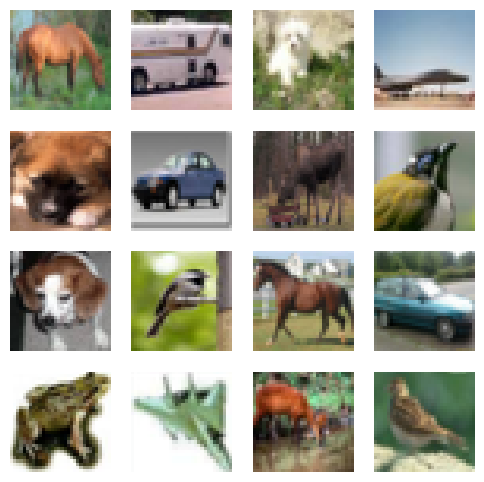

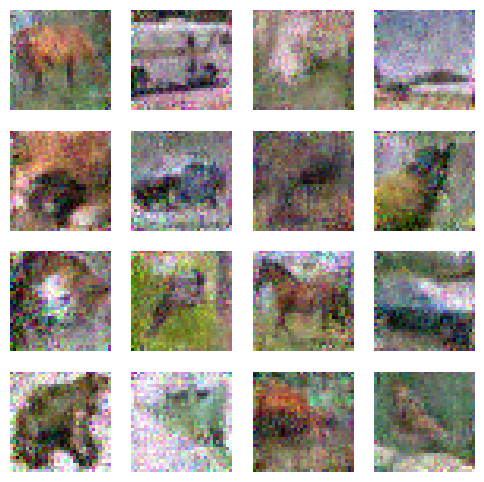

In [17]:
user.plot(true_user_data)
user.plot(reconstructed_user_data)

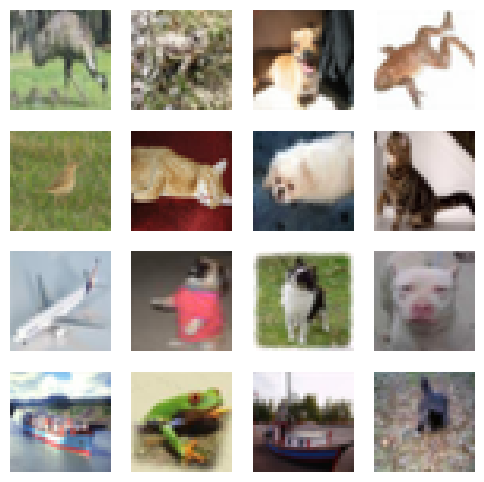

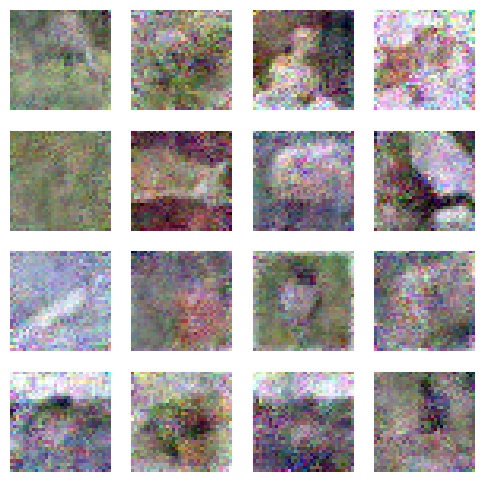

In [15]:
user.plot(true_user_data)
user.plot(reconstructed_user_data)